# With lists

Since the algorithm did not work as well as expected out of the box.

In [1]:
import pathlib
%reload_ext autoreload
%autoreload 2


import random
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
import typing as t


import core
import files_management as fm
import prepostprocessing as ppp
import utils

MAX_TAGS_PER_GNODE = 10

[files_management.py:81 -             <module>()] Outputs parent dir: /home/joaopcbertoldo/repos/pymdr
[files_management.py:91 -             <module>()] Outputs dir: /home/joaopcbertoldo/repos/pymdr/outputs


In [2]:
all_page_metas = fm.PageMeta.get_all()
print("There are {:d} pages in total.".format(len(all_page_metas)))

thresholds: t.List[float] = [th / 100 for th in range(5, 50 + 1)]
thresholds_strs = {th: "{:.2f}".format(th) for th in thresholds}
th_strs = [thresholds_strs[th] for th in thresholds]
thresholds_objs: t.Dict[float, core.MDREditDistanceThresholds] = {
    th: core.MDREditDistanceThresholds.all_equal(th) for th in thresholds
}
print("There are {:d} thresholds.".format(len(thresholds)))

all_page_metas: t.Dict[str, fm.PageMeta] = {
    k: v for k, v in all_page_metas.items() 
    if all(v.data_records_pkl(th, MAX_TAGS_PER_GNODE).exists() for th in thresholds_objs.values())
}
print("There are {:d} processed pages.".format(len(all_page_metas)))

There are 94 pages in total.
There are 46 thresholds.
There are 86 processed pages.


In [3]:
drs_by_run: t.Dict[t.Tuple[fm.PageMeta, float], t.Set[core.DataRegion]] = {
    (pmid, th): pm.load_precomputed_data_regions(th, MAX_TAGS_PER_GNODE)
    for th in thresholds
    for pmid, pm in all_page_metas.items()
}
print("There are {:d} runs of data regions.".format(len(drs_by_run)))


There are 3956 runs of data regions.


In [4]:
drecs_by_run: t.Dict[t.Tuple[str, float], t.Set[core.DataRecord]] = {
    (pmid, th): pm.load_precomputed_data_records(thresholds_objs[th], MAX_TAGS_PER_GNODE)
    for th in thresholds
    for pmid, pm in all_page_metas.items()
}
print("There are {:d} runs.".format(len(drecs_by_run)))

There are 3956 runs.


In [5]:
def get_website(url: str) -> str:
    website = url.split("//")[1].split(".com")[0]
    website = website if "www." not in website else website.split("www.")[1]
    return website

websites = {get_website(pm.url) for pm in all_page_metas.values()}

In [6]:
import pandas as pd

# pmid = page meta id, gd = ground truth
df = pd.DataFrame(
    columns=["pmid", "website", "gd"] + [thresholds_strs[th] for th in thresholds],
    data=[
        [
            pmid, get_website(pm.url), pm.n_data_records
        ] + [
            len(drecs_by_run[(pmid, th)]) for th in thresholds
        ] 
        for pmid, pm in all_page_metas.items()
    ]
)

In [7]:
def get_data_points_within_margin(pm: fm.PageMeta, size=5) -> t.Tuple[np.array, np.array, np.array]:
    """ returns: (thresholds, nb_drecs)"""
    pmrow = df[df.pmid == pm.page_id].iloc[0]
    vals = pmrow[th_strs].values
    low = pmrow.gd - size
    up = pmrow.gd + size
    withing = (vals >= low) & (vals <= up)
    ths = np.array(th_strs)
    nb_drecs = pmrow[ths[withing]].values
    ths = np.array(thresholds)[withing]
    return ths, nb_drecs, nb_drecs - pmrow.gd


In [8]:
df_diff = deepcopy(df)
df_diff[df_diff.columns[3:]] = df_diff[th_strs].values - df_diff.gd.values.reshape(-1, 1)
df_diff.head(2)

,pmid,website,gd,0.05,0.06,0.07,0.08,0.09,0.10,0.11,...,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.50
0,0d6-30e-a27,nothingbutsavings,24,-24,-24,-24,-24,-16,-12,-12,...,38,38,39,38,33,33,33,33,34,38
1,185-0cc-e49,circuitcity,12,-12,-12,-10,-10,-10,-10,-10,...,44,45,45,45,46,46,48,48,48,48


In [9]:
noises = np.random.uniform(-1, 1, len(thresholds))


def viz_page_results(pm: fm.PageMeta, figsize=None):
    row = df[df.pmid == pm.page_id].iloc[0]
    
    fig = plt.figure(figsize=figsize or (5, 5), dpi=120)
    ax = fig.gca()
    xs, ys = noises, np.array([row.get(th) for th in thresholds_strs.values()])
    ax.scatter(0, row.gd)
    ax.scatter(xs, ys, marker='x')
    ax.set_xlim(-3, 3)
    
    return fig, ax


def viz_page_th_res_curve(pm: fm.PageMeta, diff=False, figsize=None, fig=None, ax=None, sz=10):
    
    data_frame = df if not diff else df_diff
    row = data_frame[data_frame.pmid == pm.page_id].iloc[0]
    gd = row.gd if not diff else 0
    
    figsize = figsize or (sz, sz)
    fig = fig or plt.figure(figsize=figsize, dpi=120)
    ax = ax or fig.gca()
    ys = np.array([row.get(th) for th in thresholds_strs.values()])
    ax.scatter(thresholds, ys)
    ax.hlines([gd], min(thresholds), max(thresholds))
    
    return fig, ax


def viz_ths_in_margin(pm: fm.PageMeta, y_val, margin, figsize=None, fig=None, ax=None):
    
    xs, _, _ = get_data_points_within_margin(pm, margin)
    
    figsize = figsize or (10, 10)
    fig = fig or plt.figure(figsize=figsize, dpi=120)
    ax = ax or fig.gca()
    
    ax.scatter(xs, [y_val for _ in range(len(xs))])
    
    return fig, ax

In [10]:
a_pmid = list(all_page_metas.keys())[0]
a_pm = all_page_metas[a_pmid]

(<Figure size 480x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7effa97d6c18>)

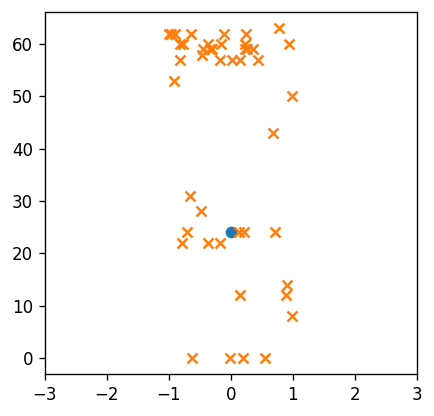

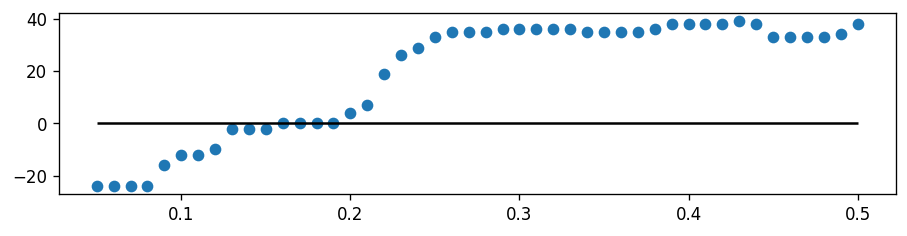

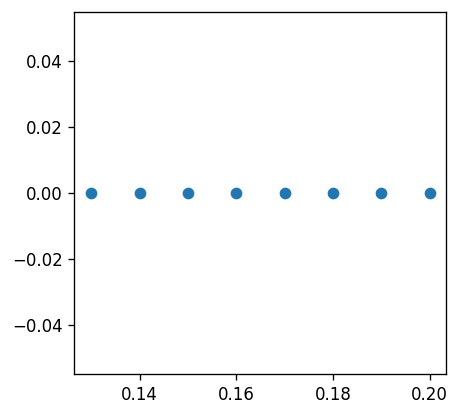

In [11]:
viz_page_results(a_pm, figsize=(4, 4))
viz_page_th_res_curve(a_pm, diff=True, figsize=(9, 2))
viz_ths_in_margin(a_pm, 0, 5, figsize=(4, 4))

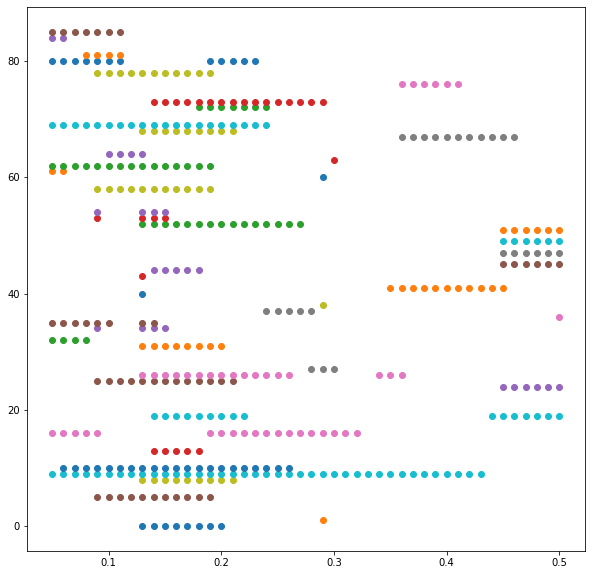

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
for idx, pm in enumerate(all_page_metas.values()):
    viz_ths_in_margin(pm, idx, 5, fig=fig, ax=ax)

In [13]:
def get_closest_ths(pm: fm.PageMeta, upto: int, maxerr=5) -> t.Tuple[np.array, np.array, np.array]:
    """ ths, n_drecs, diffs """
    ths, n_drecs, diffs = get_data_points_within_margin(pm, maxerr)
    accepted = [x for x in sorted(zip(ths, n_drecs, abs(diffs)), key=lambda x: x[1])][:upto]
    return tuple(zip(*accepted)) if accepted else (np.array([]), np.array([]), np.array([]))


def viz_closest_ths(pm: fm.PageMeta, y_val, upto, maxerr=5, figsize=None, fig=None, ax=None):
    xs, _, _ = get_closest_ths(pm, upto, maxerr)
    figsize = figsize or (10, 10)
    fig = fig or plt.figure(figsize=figsize, dpi=120)
    ax = ax or fig.gca()
    ax.scatter(xs, [y_val for _ in range(len(xs))])
    return fig, ax

In [104]:
best_ones = {
    pmid: (th, drecs_by_run[(pm.page_id, th)]) 
    for pmid, pm in all_page_metas.items()
    for th, _, _ in zip(*get_closest_ths(pm, 1, 0))
}
print(len(all_page_metas), len(best_ones))

86 16


In [105]:
a_best_pmid = list(best_ones.keys())[random.randint(0, len(best_ones) - 1)]
a_best_pm = all_page_metas[a_best_pmid]

In [106]:
a_best_th, a_best_drecs = best_ones[a_best_pmid]
a_best_drs = a_best_pm.load_precomputed_data_regions(a_best_th, 10)
a_best_doc = a_best_pm.get_named_nodes_html_tree()

In [107]:
# a_best_drecs

In [108]:
data_records_nodes = core.get_data_records_as_nodes(a_best_doc, a_best_drecs)

In [109]:
core.paint_data_records(data_records_nodes)
fm.PageMeta.persist_html(a_best_pm.colored_html, a_best_doc)
print(str(a_best_pm.colored_html))

/home/joaopcbertoldo/repos/pymdr/outputs/results/2020-03-23-2300---c62-963-bfa-colored.html


In [110]:
for a_best_pmid in list(best_ones.keys()):
    try:
        a_best_pm = all_page_metas[a_best_pmid]
        a_best_th, a_best_drecs = best_ones[a_best_pmid]
        a_best_drs = a_best_pm.load_precomputed_data_regions(a_best_th, 10)
        a_best_doc = a_best_pm.get_named_nodes_html_tree()
        data_records_nodes = core.get_data_records_as_nodes(a_best_doc, a_best_drecs)
        if any(len(drec) == 0 for drec in data_records_nodes):
            print(a_best_pmid)
    except Exception as ex:
        import traceback
        print(ex)
        print(a_best_pmid)
        traceback.print_stack()


In [112]:
for a_best_pmid in list(best_ones.keys()):
    try:
        a_best_pm = all_page_metas[a_best_pmid]
        a_best_th, a_best_drecs = best_ones[a_best_pmid]
        a_best_drs = a_best_pm.load_precomputed_data_regions(a_best_th, 10)
        a_best_doc = a_best_pm.get_named_nodes_html_tree()
        data_records_nodes = core.get_data_records_as_nodes(a_best_doc, a_best_drecs)
        core.paint_data_records(data_records_nodes)
        fm.PageMeta.persist_html(a_best_pm.colored_html, a_best_doc)
        
        print(a_best_pm.n_data_records)
        print(a_best_pm.url)
        print(str(a_best_pm.raw_html))
        print(str(a_best_pm.colored_html))
        print("")
    
    except Exception as ex:
        import traceback
        print(ex)
        print(a_best_pmid)
        traceback.print_stack()
    

24
https://www.nothingbutsavings.com/Category/9-For-the-Home
/home/joaopcbertoldo/repos/pymdr/outputs/raw_htmls/2020-03-24-0046---0d6-30e-a27-raw.html
/home/joaopcbertoldo/repos/pymdr/outputs/results/2020-03-24-0046---0d6-30e-a27-colored.html

12
https://www.toysrus.com/shop-by-category/games-and-puzzles/puzzles/
/home/joaopcbertoldo/repos/pymdr/outputs/raw_htmls/2020-03-24-0014---23e-d57-219-raw.html
/home/joaopcbertoldo/repos/pymdr/outputs/results/2020-03-24-0014---23e-d57-219-colored.html

24
https://www.nothingbutsavings.com/Category/175-Servers
/home/joaopcbertoldo/repos/pymdr/outputs/raw_htmls/2020-03-24-0046---2e0-fe9-53b-raw.html
/home/joaopcbertoldo/repos/pymdr/outputs/results/2020-03-24-0046---2e0-fe9-53b-colored.html

28
https://www.barnesandnoble.com/b/coming-soon/books/_/N-1oyfZ29Z8q8
/home/joaopcbertoldo/repos/pymdr/outputs/raw_htmls/2020-03-23-2300---347-344-928-raw.html
/home/joaopcbertoldo/repos/pymdr/outputs/results/2020-03-23-2300---347-344-928-colored.html

20
http: